In [6]:
import os
import random
import string
from PIL import Image, ImageDraw, ImageFont
# os.environ["CUDA_VISIBLE_DEVICES"] = '0'
import torch
import torchvision  # Add this line
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import torch.optim as optim
from tqdm import tqdm
import torch.nn.functional as F
import shutil
from torchvision.transforms.functional import to_pil_image
import numpy as np

In [7]:
# 数据转换
# Dataset paths
WATERMARKED_DIR = "./web_dataset_split/test1/watermarked"
MASK_DIR = "./web_test_mask_results"
CLEAN_DIR = "./web_dataset_split/test1/no_watermark"
OUTPUT_DIR = "./web_test_model_result/watermark_removal_output"

# Hyperparameters
EPOCHS = 10
LEARNING_RATE = 0.001
BATCH_SIZE = 4

# Data transforms
transform = transforms.Compose([
    transforms.ToTensor()
])

transform = transforms.Compose([
    transforms.ToTensor()
])

# 自定义数据集
class WatermarkRemovalDataset(Dataset):
    def __init__(self, watermarked_dir, mask_dir, clean_dir, transform=None):
        self.watermarked_dir = watermarked_dir
        self.mask_dir = mask_dir
        self.clean_dir = clean_dir
        self.images = sorted(os.listdir(watermarked_dir))
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        watermarked_path = os.path.join(self.watermarked_dir, self.images[idx])
        mask_path = os.path.join(self.mask_dir, self.images[idx])
        clean_path = os.path.join(self.clean_dir, self.images[idx])

        watermarked_img = Image.open(watermarked_path).convert("RGB")
        mask_img = Image.open(mask_path).convert("L")  # Mask is 单通道
        clean_img = Image.open(clean_path).convert("RGB")

            # Convert mask to binary (0 and 1)
        mask_array = np.array(mask_img) > 128
        mask_img = Image.fromarray(mask_array.astype(np.uint8) * 255)

        if self.transform:
            watermarked_img = self.transform(watermarked_img)
            mask_img = self.transform(mask_img)
            clean_img = self.transform(clean_img)

        # 返回四个值：watermarked_img, mask_img, clean_img, filename
        return watermarked_img, mask_img, clean_img, self.images[idx]

# 自定义 collate_fn
def custom_collate_fn(batch):
    watermarked_imgs, masks, clean_imgs, filenames = zip(*batch)
    return list(watermarked_imgs), list(masks), list(clean_imgs), list(filenames)

# 数据加载器
train_dataset = WatermarkRemovalDataset(
    watermarked_dir="./web_dataset_split/test1/watermarked",
    mask_dir="./web_test_mask_results",
    clean_dir="./web_dataset_split/test1/no_watermark",
    transform=transform
)

train_loader = DataLoader(
    train_dataset,
    batch_size=1,
    shuffle=True,
    collate_fn=custom_collate_fn
)

In [8]:
# Watermark Removal Model
class WatermarkInpaintingModel(nn.Module):
    def __init__(self):
        super(WatermarkInpaintingModel, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(4, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.middle = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 3, kernel_size=2, stride=2),
            nn.Sigmoid()  # Normalize output to [0, 1]
        )

    def forward(self, watermarked_img, mask):
        x = torch.cat((watermarked_img, mask), dim=1)  # Concatenate image and mask
        x = self.encoder(x)
        x = self.middle(x)
        x = self.decoder(x)
        return x


# Loss function
def loss_function(predicted_img, clean_img, mask):
    mse_loss = nn.MSELoss()
    l1_loss = nn.L1Loss()

    # Compute losses
    reconstruction_loss = mse_loss(predicted_img, clean_img)
    context_loss = l1_loss(predicted_img * (1 - mask), clean_img * (1 - mask))

    # Combine losses
    total_loss = reconstruction_loss + context_loss
    return total_loss

In [9]:
from tqdm import tqdm
import torch.nn.functional as F
import os

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
EPOCHS = 10
LEARNING_RATE = 0.001

# Model, optimizer, and loss
model = WatermarkInpaintingModel().to(DEVICE)
criterion = loss_function
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Training loop
print("Starting training...")
for epoch in range(EPOCHS):
    model.train()
    epoch_loss = 0

    for watermarked_imgs, masks, clean_imgs, file_names in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{EPOCHS}"):
        # Stack inputs into batches and send to device
        watermarked_imgs = torch.stack(watermarked_imgs).to(DEVICE)
        masks = torch.stack(masks).to(DEVICE)
        clean_imgs = torch.stack(clean_imgs).to(DEVICE)

        optimizer.zero_grad()

        # Forward pass
        outputs = model(watermarked_imgs, masks)

        # Ensure output has the same size as the original image
        outputs_resized = F.interpolate(outputs, size=watermarked_imgs.shape[2:], mode="bilinear", align_corners=True)

        # Compute loss
        loss = criterion(outputs_resized, clean_imgs, masks)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    print(f"Epoch {epoch + 1}/{EPOCHS}, Loss: {epoch_loss / len(train_loader):.4f}")

# Save the model
# Save the model in the same directory as the script or notebook
model_path = "web_watermark_removal_model.pth"  # Save in the current directory
torch.save(model.state_dict(), model_path)
print(f"Model saved at: {model_path}")


Starting training...


Epoch 1/10: 100%|██████████| 4000/4000 [01:21<00:00, 49.20it/s]


Epoch 1/10, Loss: 0.0474


Epoch 2/10: 100%|██████████| 4000/4000 [00:31<00:00, 126.97it/s]


Epoch 2/10, Loss: 0.0365


Epoch 3/10: 100%|██████████| 4000/4000 [00:31<00:00, 127.49it/s]


Epoch 3/10, Loss: 0.0341


Epoch 4/10: 100%|██████████| 4000/4000 [00:31<00:00, 128.70it/s]


Epoch 4/10, Loss: 0.0327


Epoch 5/10: 100%|██████████| 4000/4000 [00:29<00:00, 134.11it/s]


Epoch 5/10, Loss: 0.0321


Epoch 6/10: 100%|██████████| 4000/4000 [00:33<00:00, 118.47it/s]


Epoch 6/10, Loss: 0.0309


Epoch 7/10: 100%|██████████| 4000/4000 [00:31<00:00, 126.21it/s]


Epoch 7/10, Loss: 0.0307


Epoch 8/10: 100%|██████████| 4000/4000 [00:31<00:00, 125.45it/s]


Epoch 8/10, Loss: 0.0304


Epoch 9/10: 100%|██████████| 4000/4000 [00:31<00:00, 125.16it/s]


Epoch 9/10, Loss: 0.0297


Epoch 10/10: 100%|██████████| 4000/4000 [00:33<00:00, 119.59it/s]

Epoch 10/10, Loss: 0.0295
Model saved at: web_watermark_removal_model.pth


In [17]:
from torchvision.transforms.functional import to_pil_image
import os

def remove_watermark(test_loader, model_path, output_dir):
    os.makedirs(output_dir, exist_ok=True)
    model = WatermarkInpaintingModel().to(DEVICE)
    model.load_state_dict(torch.load(model_path, map_location=DEVICE))
    model.eval()

    with torch.no_grad():
        for watermarked_imgs, masks, clean_imgs ,filenames in test_loader:  # filenames 从数据集中获取
            for watermarked_img, mask, clean_img ,filename in zip(watermarked_imgs, masks, clean_imgs, filenames):
                watermarked_img = watermarked_img.to(DEVICE).unsqueeze(0)
                mask = mask.to(DEVICE).unsqueeze(0)

                output = model(watermarked_img, mask)

                # 动态调整输出尺寸
                original_size = watermarked_img.shape[2:]
                output = torch.nn.functional.interpolate(output, size=original_size, mode='bilinear', align_corners=True)

                output = output.squeeze(0).cpu()
                output_img = to_pil_image(output)

                # 保存文件，确保文件名和扩展名正确
                base_name, ext = os.path.splitext(filename)
                if ext.lower() not in [".jpg", ".jpeg", ".png"]:
                    ext = ".png"  # 默认扩展名
                output_path = os.path.join(output_dir, f"{base_name}{ext}")
                output_img.save(output_path)

                print(f"Saved: {output_path}")

    print("Watermark removal complete.")


In [18]:
# Testing the model
test_dataset = WatermarkRemovalDataset(
    watermarked_dir="./web_dataset_split/test2/watermarked",
    mask_dir="./web_test_model_result/mask",
    clean_dir="./web_dataset_split/test2/no_watermark",
    transform=transform
)

test_loader = DataLoader(
    test_dataset,
    batch_size=1,
    shuffle=False,
    collate_fn=custom_collate_fn
)

remove_watermark(test_loader, "web_watermark_removal_model.pth", OUTPUT_DIR)

C:\Users\EdisonLai\AppData\Local\Temp\ipykernel_3128\714315166.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=

Saved: ./web_test_model_result/watermark_removal_output\777.jpeg
Saved: ./web_test_model_result/watermark_removal_output\7770.jpeg
Saved: ./web_test_model_result/watermark_removal_output\7771.jpeg
Saved: ./web_test_model_result/watermark_removal_output\7772.jpeg
Saved: ./web_test_model_result/watermark_removal_output\7773.jpeg
Saved: ./web_test_model_result/watermark_removal_output\7774.jpeg
Saved: ./web_test_model_result/watermark_removal_output\7775.jpeg
Saved: ./web_test_model_result/watermark_removal_output\7776.jpeg
Saved: ./web_test_model_result/watermark_removal_output\7777.jpeg
Saved: ./web_test_model_result/watermark_removal_output\7778.jpeg
Saved: ./web_test_model_result/watermark_removal_output\7779.jpeg
Saved: ./web_test_model_result/watermark_removal_output\778.jpeg
Saved: ./web_test_model_result/watermark_removal_output\7780.jpeg
Saved: ./web_test_model_result/watermark_removal_output\7781.jpeg
Saved: ./web_test_model_result/watermark_removal_output\7782.jpeg
Saved: ./web

In [23]:
test_dataset = WatermarkRemovalDataset(
    watermarked_dir="./true_web_data/watermarked",
    mask_dir="./true_web_data/model2/predicted_mask",
    clean_dir="./true_web_data/no_watermark",
    transform=transform
)

test_loader = DataLoader(
    test_dataset,
    batch_size=1,
    shuffle=False,
    collate_fn=custom_collate_fn
)

output_dir="./true_web_data/model2/output_no_watermark"

remove_watermark(test_loader, "web_watermark_removal_model.pth", output_dir)



C:\Users\EdisonLai\AppData\Local\Temp\ipykernel_3128\714315166.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=

Saved: ./true_web_data/model2/output_no_watermark\13000.jpeg
Saved: ./true_web_data/model2/output_no_watermark\13001.jpeg
Saved: ./true_web_data/model2/output_no_watermark\13002.jpg
Saved: ./true_web_data/model2/output_no_watermark\13003.jpg
Saved: ./true_web_data/model2/output_no_watermark\13004.jpg
Saved: ./true_web_data/model2/output_no_watermark\13005.jpg
Saved: ./true_web_data/model2/output_no_watermark\13006.jpg
Saved: ./true_web_data/model2/output_no_watermark\13007.jpg
Saved: ./true_web_data/model2/output_no_watermark\13008.jpg
Saved: ./true_web_data/model2/output_no_watermark\13010.jpg
Saved: ./true_web_data/model2/output_no_watermark\13011.png
Saved: ./true_web_data/model2/output_no_watermark\n02094258_5244.jpg
Saved: ./true_web_data/model2/output_no_watermark\n02096437_1199.jpg
Saved: ./true_web_data/model2/output_no_watermark\n02096437_2218.jpg
Saved: ./true_web_data/model2/output_no_watermark\n04418357_15553v2.jpg
Saved: ./true_web_data/model2/output_no_watermark\n04429376

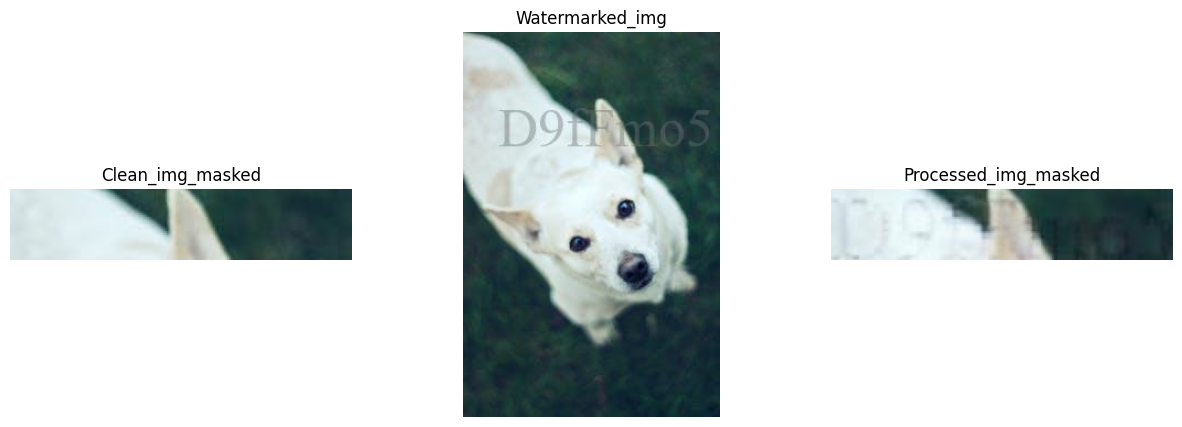

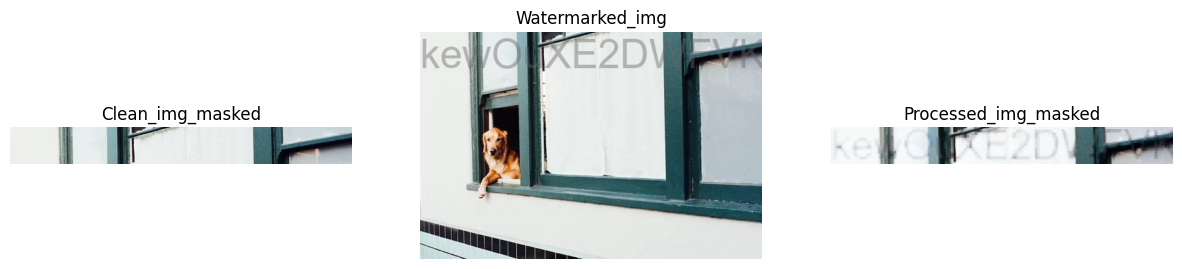

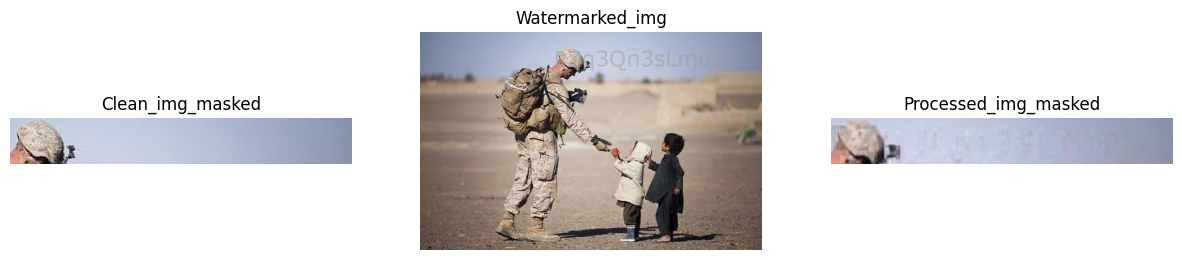

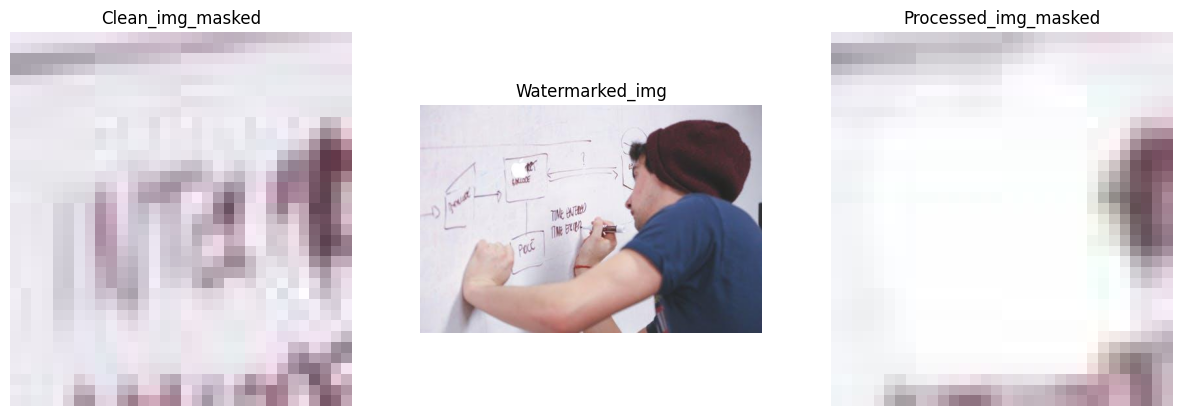

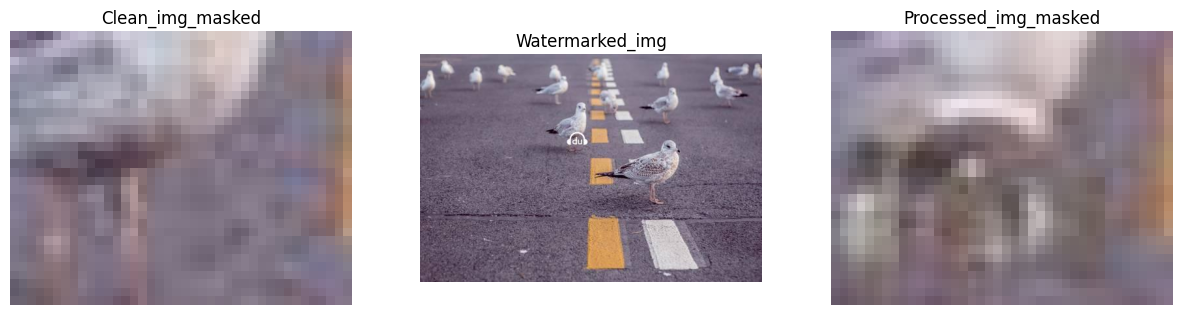

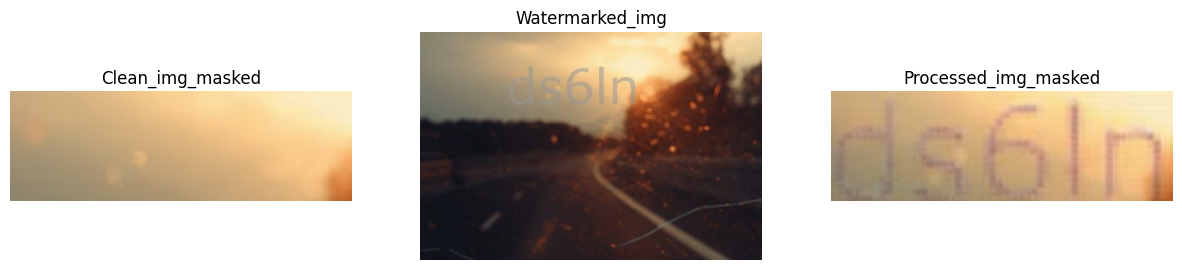

去浮水印正確率: 28.02%
平均 SSIM 分數: 0.5545


In [21]:
from skimage.metrics import structural_similarity as ssim
from skimage.io import imread
import matplotlib.pyplot as plt
from natsort import natsorted
import numpy as np

def calculate_accuracy_with_only_watermark_region(clean_images_dir, watermarked_images_dir, processed_images_dir, mask_dir, similarity_threshold=0.9):
    """
    計算去浮水印模型的正確率，只考慮浮水印及其周圍區域，不考慮其他區域。

    :param clean_images_dir: 原始圖片文件夾路徑
    :param processed_images_dir: 去浮水印圖片文件夾路徑
    :param mask_dir: 浮水印區域掩膜文件夾路徑，該掩膜標識浮水印位置（1表示浮水印區域，0表示非浮水印區域）
    :param similarity_threshold: SSIM 判斷閾值
    :return: 正確率，平均 SSIM 分數
    """
    clean_images = natsorted(os.listdir(clean_images_dir))
    watermarked_images = natsorted(os.listdir(watermarked_images_dir))
    processed_images = natsorted(os.listdir(processed_images_dir))
    masks = natsorted(os.listdir(mask_dir))

    if len(clean_images) != len(processed_images) or len(clean_images) != len(masks):
        raise ValueError("圖片數量或掩膜數量不一致！")

    total_images = len(clean_images)
    correct_count = 0
    total_score = 0
    time = 6

    for clean_image, watermarked_image, processed_image, mask_name in zip(clean_images, watermarked_images, processed_images, masks):
        # 讀取圖片和掩膜
        clean_img = imread(os.path.join(clean_images_dir, clean_image))
        watermarked_img = imread(os.path.join(watermarked_images_dir, watermarked_image))
        processed_img = imread(os.path.join(processed_images_dir, processed_image))
        mask = imread(os.path.join(mask_dir, mask_name))

        # 掩膜區域：1 表示浮水印區域
        watermark_region = mask > 0.4

        # 計算水印區域的矩形框
        coords = np.argwhere(watermark_region)
        if coords.size == 0:
            print(f"掩膜 {mask_name} 中沒有標註浮水印區域，跳過此影像！")
            total_images -= 1  # 減少總影像計數
            continue
        y_min, x_min = coords.min(axis=0)
        y_max, x_max = coords.max(axis=0)

        rectangular_mask = np.zeros_like(mask, dtype=bool)
        rectangular_mask[y_min:y_max+1, x_min:x_max+1] = True

        clean_img_masked = clean_img[y_min:y_max+1, x_min:x_max+1]
        processed_img_masked = processed_img[y_min:y_max+1, x_min:x_max+1]

        fig, ax = plt.subplots(1, 3, figsize=(15, 5))
        # 顯示調試用的矩形框掩
        if time > 0:
            # 顯示水印圖片
            ax[0].imshow(clean_img_masked)
            ax[0].set_title("Clean_img_masked")
            ax[0].axis('off')
            # 顯示矩形掩膜
            ax[1].imshow(watermarked_img, cmap='gray')
            ax[1].set_title("Watermarked_img")
            ax[1].axis('off')
            # 顯示處理後的圖片
            ax[2].imshow(processed_img_masked)
            ax[2].set_title("Processed_img_masked")
            ax[2].axis('off')
            plt.pause(0.5)  # 暫停 0.5 秒，模擬實時更新
            time -= 1
        
        data_range = clean_img.max() - clean_img.min()
        # 計算 SSIM
        score, _ = ssim(
            clean_img_masked, 
            processed_img_masked, 
            channel_axis=-1,  # 指定最後一軸是顏色通道
            data_range=data_range, 
            full=True,
        )
        if score >= similarity_threshold:
            correct_count += 1
        total_score += score

        # 清空圖形窗口
        plt.close('all')

    accuracy = correct_count / total_images
    average_score = total_score / total_images  # 計算平均 SSIM 分數
    return accuracy, average_score

# Step 3: 設定圖片文件夾路徑並計算正確率
clean_images_dir = "web_dataset_split/test2/no_watermark"  # 原始圖片路徑
watermarked_images_dir = "web_dataset_split/test2/watermarked"  # 原始浮水印圖片路徑
processed_images_dir = "web_test_model_result/watermark_removal_output"  # 浮水印結果路徑
mask_dir = "web_dataset_split/test2/masks"  # 浮水印區域掩膜的路徑

similarity_threshold = 0.7  # 設置 SSIM 判斷閾值

accuracy, average_score = calculate_accuracy_with_only_watermark_region(
    clean_images_dir, watermarked_images_dir, processed_images_dir, mask_dir, similarity_threshold
)

print(f"去浮水印正確率: {accuracy * 100:.2f}%")
print(f"平均 SSIM 分數: {average_score:.4f}")
